# Day 1: Interpretable and Explainable Machine Learning + Causal Inference

### Set up the environment

In [1]:
# Imports for handling files, data and plots
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import warnings
from IPython.display import display, Markdown
from graphviz import Digraph

# Imports for methods and models
import sklearn
import xgboost
import statsmodels
from dowhy import CausalModel
from econml.dml import CausalForestDML
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
import shap


# Set random seed for reproducibility
np.random.seed(47176870)

### Donwload and inspect the structured data

We will work with the California housing dataset. This dataset contains 20,640 observations on the average house value as target variable and 8 input variables (features): average income,
housing average age, average rooms, average bedrooms, population, average occupation, latitude, and longitude. The original data are available from StatLib http://lib.stat.cmu.edu/datasets/, or for direct download at https://ndownloader.figshare.com/files/5976036 .

References: Pace, R. K. and Barry, R. (1997). Sparse Spatial Autoregressions,Statistics and Probability Letters, 33 (1997), 291-297.

In [2]:
# Download the data set in array format from the sklearn library
housing_dataset = sklearn.datasets.fetch_california_housing(
    download_if_missing=True
)

In [3]:
# Format the "x" variable (housing prices)
X = pd.DataFrame(data=housing_dataset.data,
                 columns=housing_dataset.feature_names)

# Format the "y" variables (average income, housing average age, average rooms, average bedrooms, population, average occupation, latitude, and longitude)
y = housing_dataset.target

In [4]:
# Summarize the features using pandas
X.describe(include='all')

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


In [5]:
# Select a smaller subset of the data for faster processing

reduce_sample_size = False

if reduce_sample_size:
    n_points = 1000
    if n_points is not None:
        # random_state fixes the random seed for reproducibility
        X = shap.utils.sample(X, n_points, random_state=47176870)
        # random_state fixes the random seed for reproducibility
        y = shap.utils.sample(y, n_points, random_state=47176870)

### Split the data and train a model

In [6]:
# Split the data set in train and test data (20% for testing)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=47176870
)

Shallow Tree Accuracy on Train Data: 0.806533827026405
Shallow Tree Accuracy on Test Data: 0.791928575265526


Text(0.5, 1.0, 'Model Fit: True vs Predicted Housing Prices')

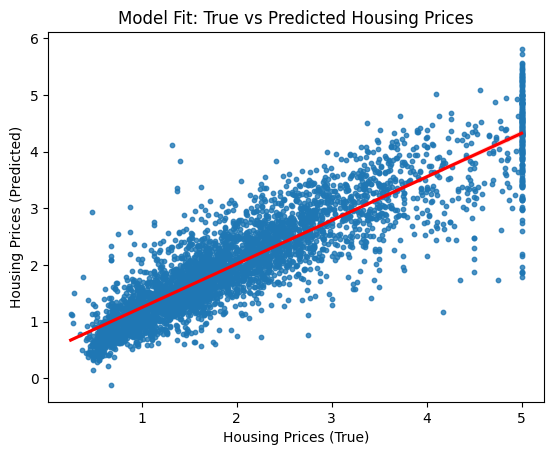

In [7]:
# Create an extreme gradient boosting model to predict the housing prices from the available features (ensemble of regression trees)

model_xgb = xgboost.XGBRegressor(
    n_estimators=100,  # number of trees
    max_depth=2,
)  # maximum depth of each tree (here we are allowing for two levels of splits: shallow trees)
# Other parameters set to default values, more information in the documentation or help(xgboost.XGBRegressor)

# Fit the model to the training data
model_xgb = model_xgb.fit(X_train, y_train)
print(f"Shallow Tree Accuracy on Train Data: {model_xgb.score(X_train, y_train)}")
print(f"Shallow Tree Accuracy on Test Data: {model_xgb.score(X_test, y_test)}")

# Plot the predictions of the model against the true values (test data)

# plt.scatter(y_test, y_pred_test)  # seen data
# plt.xlabel('Housing Prices (True)')
# plt.ylabel('Housing Prices (Predicted)')
# plt.title('Model Fit: True vs Predicted Housing Prices')

y_pred_test = model_xgb.predict(X_test)
sns.regplot(x=y_test, y=y_pred_test, scatter_kws={"s": 10}, line_kws={"color": "red"})
plt.xlabel("Housing Prices (True)")
plt.ylabel("Housing Prices (Predicted)")
plt.title("Model Fit: True vs Predicted Housing Prices")


### Explain the model with SHAP

In [8]:
# Create an "explainer" object to explain the model predictions
explainer_xgb = shap.Explainer(model_xgb, X_test)  # use the test data
# X100 = shap.utils.sample(X_test, 100)  # alternatively: restrict to 100 instances for faster computation

# Compute the SHAP values for the test data
shap_values_xgb = explainer_xgb(X_test)

### Partial dependence plot

Text(0.5, 1.0, 'Partial Dependence Plot for Average Income')

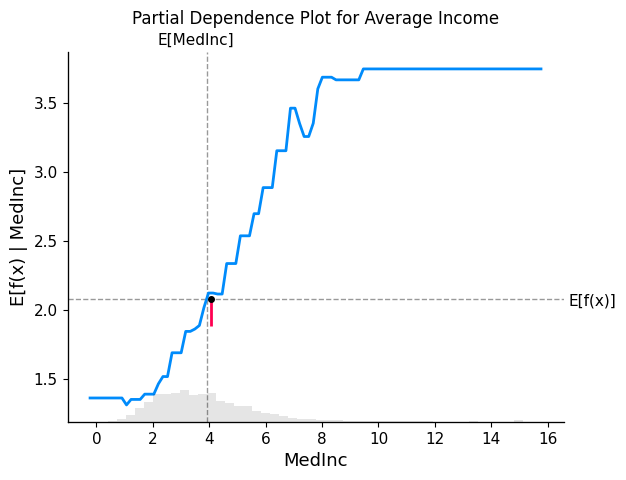

In [9]:
# Make a standard partial dependence plot with a single SHAP value overlaid

sample_ind = 20

shap.partial_dependence_plot(
    "MedInc",  # average income
    model_xgb.predict,
    X_test,
    model_expected_value=True,  # also show the expected value of the target
    feature_expected_value=True,  # also show the expected value of the feature
    show=False,
    ice=False,
    # overlay one instance in red
    shap_values=shap_values_xgb[sample_ind: sample_ind + 1, :],
)
plt.title("Partial Dependence Plot for Average Income")


### Individual conditional expectation plot

Text(0.5, 1.0, 'Partial Dependence Plot for Average Income')

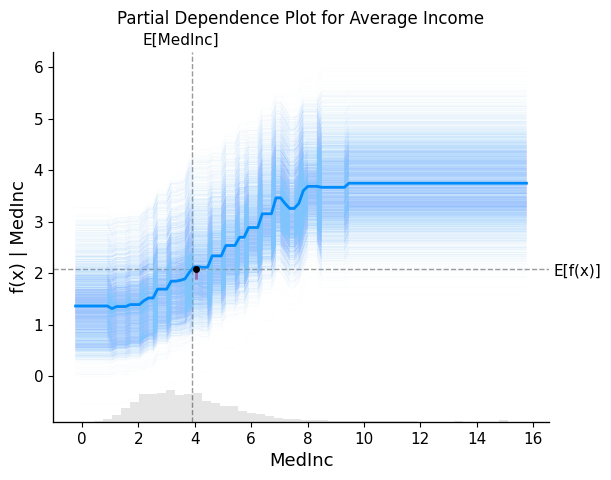

In [10]:
# Make a standard invididual conditional expectation plot with a single SHAP value overlaid

sample_ind = 20

shap.partial_dependence_plot(
    "MedInc",  # average income
    model_xgb.predict,
    X_test,
    model_expected_value=True,  # also show the expected value of the target
    feature_expected_value=True,  # also show the expected value of the feature
    show=False,
    ice=True,
    # overlay one instance in red
    shap_values=shap_values_xgb[sample_ind: sample_ind + 1, :],
)
plt.title("Partial Dependence Plot for Average Income")

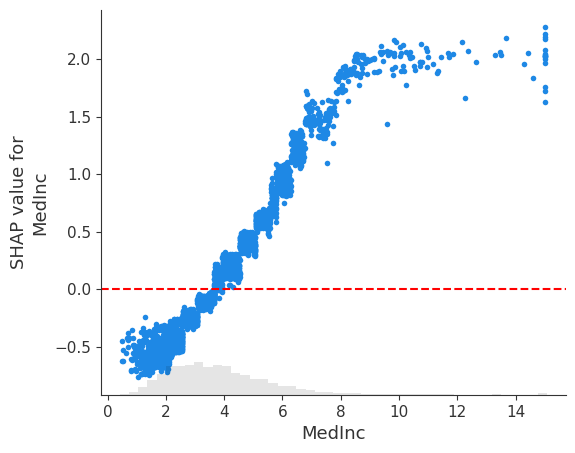

In [11]:
# Scatter plot of SHAP values for the feature "MedInc" (average income)
shap.plots.scatter(shap_values_xgb[:, "MedInc"], show=False)
plt.axhline(y=0, color='red', linestyle='--')

### Inspect interaction effects

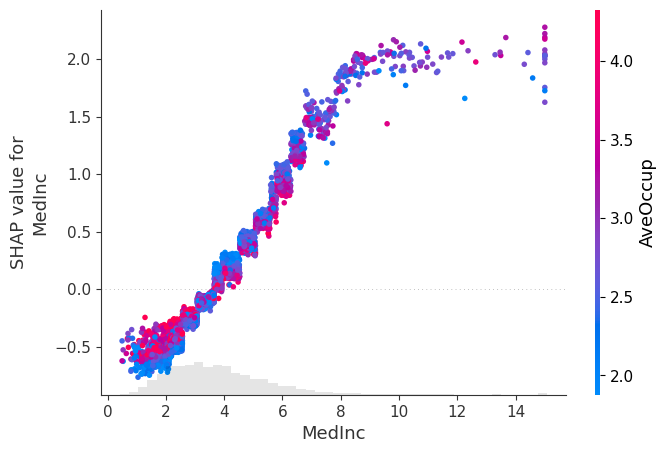

In [12]:
# Inspect interaction effecs: Plot the SHAP values for the feature "MedInc" (average income)
# against the feature "AveOccup" (average occupation)
shap.plots.scatter(
    shap_values_xgb[:, "MedInc"],
    color=shap_values_xgb[:, "AveOccup"],
)


### Explanations for several features at once

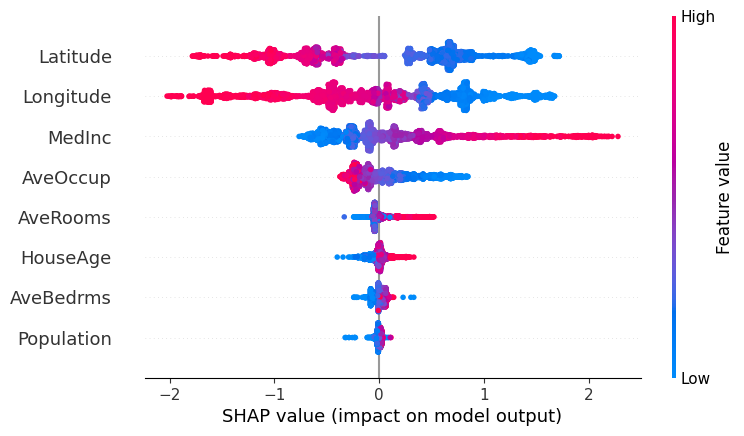

In [13]:
# Visualize several features using a beeswarm plot
shap.plots.beeswarm(shap_values_xgb)

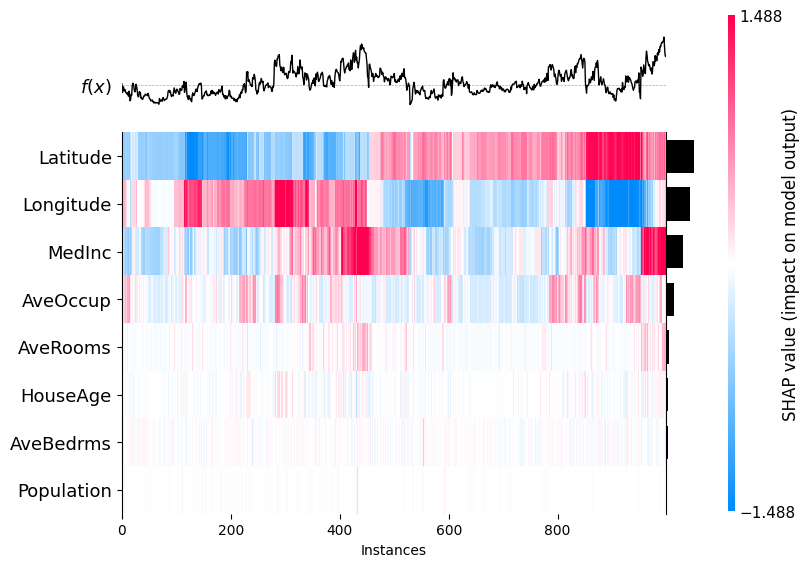

<Axes: xlabel='Instances'>

In [14]:
# Visualize several features using a heatmap
shap.plots.heatmap(shap_values_xgb[:1000])

### Local explanations for a single observation (similar to LIME - Local Interpretable Model-Agnostic Explanations)

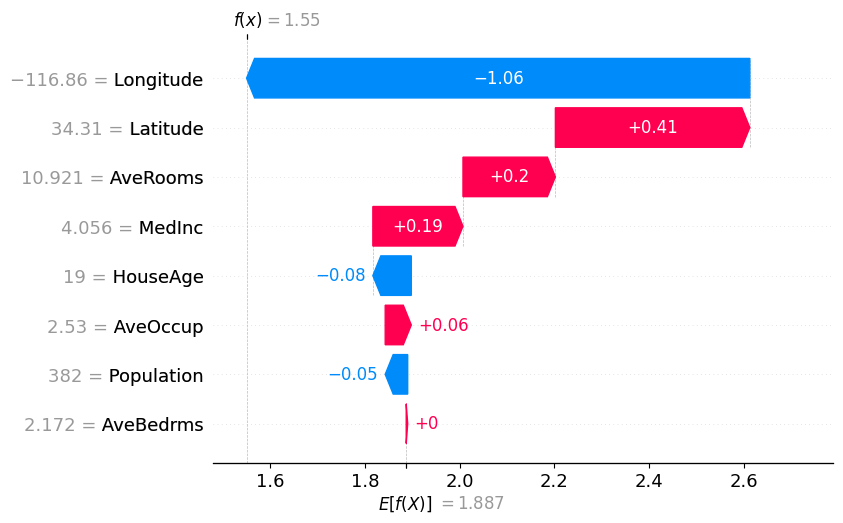

In [15]:
# Explain the model predictions for a single instance (sample_ind) using a waterfall plot
shap.plots.waterfall(shap_values_xgb[sample_ind], max_display=14)

# For observation 20 in the test data: being further west (negative longitude) has a negative effect on the predicted housing price
# Being further north (positive latitude) has a positive effect on the predicted housing price
# Having a higher number of rooms has a positive effect on predicted housing price

# Day 1: Causal Inference

### Create a synthetic data where we **know** the true (causal) structure

Subject: subscriber retention (source: https://shap.readthedocs.io/en/latest/example_notebooks/overviews/Be%20careful%20when%20interpreting%20predictive%20models%20in%20search%20of%20causal%20insights.html)

**Features:** 
- **Sales calls:** The number of sales calls made to each customer. 

- **Interactions:** The total number of interactions with the customer.

- **Economy:** The health of the regional economy the customer is part of. 

- **Last upgrade:** The time since the last product upgrade when the customer came up for renewal. 

- **Product need:** How much the user perceives they need the product. 

- **Discount:** The fractional discount offered to the customer upon renewal. 

- **Monthly usage:** The percentage of days in the last period the user was actively using the product. 

- **Ad spend:** The amount of ad money spent per user targeted at this user. 

- **Bugs faced:** The number of bugs encountered by the user since their last renewal. 

- **Bugs reported:** The number of bugs reported by the user. 

- **Did renew:** The probability that the user renewed their subscription. 

In [16]:
# Create a helper function to handle "fixed" variables, like a dictionary in artificially generated data

class FixableDataFrame(pd.DataFrame):

    def __init__(self, *args, fixed={}, **kwargs):
        self.__dict__["__fixed_var_dictionary"] = fixed
        super().__init__(*args, **kwargs)

    def __setitem__(self, key, value):
        out = super().__setitem__(key, value)
        if isinstance(key, str) and key in self.__dict__["__fixed_var_dictionary"]:
            out = super().__setitem__(key, self.__dict__[
                "__fixed_var_dictionary"][key])
        return out

In [17]:
# Function for generating synthetic data for the subscriber retention example


def generator(n, fixed={}, seed=47176870, draw_renewal=False):
    if seed is not None:
        np.random.seed(seed)
    X = FixableDataFrame(fixed=fixed)  # use the previous helper function

    # Number of sales calls made to this customer
    # Uniform random variable between 0 and 4, rounded to the nearest integer.
    X["Sales calls"] = np.random.uniform(0, 4, size=(n,)).round()

    # Number of sales calls made to this customer
    X["Interactions"] = X["Sales calls"] + np.random.poisson(0.2, size=(n,))

    # Health of the regional economy this customer is a part of
    X["Economy"] = np.random.uniform(0, 1, size=(n,))

    # Time since the last product upgrade when this customer came up for renewal
    X["Last upgrade"] = np.random.uniform(0, 20, size=(n,))

    # How much the user perceives that they need the product
    X["Product need"] = X["Sales calls"] * 0.1 + np.random.normal(0, 1, size=(n,))

    # Fractional discount offered to this customer upon renewal
    # Logistic sigmoid function (scipy.special.expit) on the product need, combined with a uniform random variable between 0 and 1, and then divided by 2.
    X["Discount"] = (
        (1 - scipy.special.expit(X["Product need"])) * 0.5
        + 0.5 * np.random.uniform(0, 1, size=(n,))
    ) / 2

    # % of days in the last period in which the user actively used the product
    # Logistic sigmoid function on 0.3 times the product need plus a normal random variable with mean 0 and standard deviation 1.
    X["Monthly usage"] = scipy.special.expit(
        X["Product need"] * 0.3 + np.random.normal(0, 1, size=(n,))
    )

    # How much ad money spent per user targeted at this user (or a group this user is in)
    # Calculated using the monthly usage, a uniform random variable between 0.9 and 0.99, and conditions based on the last upgrade time.
    X["Ad spend"] = (
        X["Monthly usage"] * np.random.uniform(0.99, 0.9, size=(n,))
        + (X["Last upgrade"] < 1)
        + (X["Last upgrade"] < 2)
    )

    # how many bugs did this user encounter in the since their last renewal
    # Poisson random variable with a mean of 2 times the monthly usage.
    X["Bugs faced"] = np.array([np.random.poisson(v * 2) for v in X["Monthly usage"]])

    # How many bugs did the user report?
    # Number of bugs faced times the logistic sigmoid function of the product need, rounded to the nearest integer.
    X["Bugs reported"] = (
        X["Bugs faced"] * scipy.special.expit(X["Product need"])
    ).round()

    # Did the user renew the subscription?
    # This is calculated using a logistic regression model with various features including product need, monthly usage, economy,
    # discount, bugs faced, sales calls, interactions, last upgrade, and ad spend. The result is a probability value between 0 and 1.
    # Optionally, if draw_renewal is set to True, the Did renew column is converted from a probability to a binary outcome (0 or 1) using a Bernoulli random variable.

    # Having the target as a probability allows for less noise in the plots. Using a binary outcome gives similar results, but with noisier causal effect lines.

    X["Did renew"] = scipy.special.expit(
        7
        * (
            0.18 * X["Product need"]
            + 0.08 * X["Monthly usage"]
            + 0.1 * X["Economy"]
            + 0.05 * X["Discount"]
            + 0.05 * np.random.normal(0, 1, size=(n,))
            + 0.05 * (1 - X["Bugs faced"] / 20)
            + 0.005 * X["Sales calls"]
            + 0.015 * X["Interactions"]
            + 0.1 / (X["Last upgrade"] / 4 + 0.25)
            + X["Ad spend"] * 0.0
            - 0.45
        )
    )

    # in real life we would make a random draw to get either 0 or 1 for if the
    # customer did or did not renew. but here we leave the label as the probability
    # so that we can get less noise in our plots. Activate this line to get
    # noiser causal effect lines but the same basic results
    if draw_renewal:
        X["Did renew"] = scipy.stats.bernoulli.rvs(X["Did renew"])

    return X


In [18]:
# Function for drawing from the synthetic data set

def user_retention_dataset():
    """The observed data for model training."""
    n = 10000
    df_full = generator(n)
    y = df_full["Did renew"]
    X = df_full.drop(["Did renew", "Product need", "Bugs faced"], axis=1)
    return X, y, df_full

### Generate the synthetic data and split the sample in train and test data

In [19]:
# Generate the synthetic data set and split it into train and test data

X, y, df_full = user_retention_dataset()  # generate data set
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y
)  # train/test split by default splitting in 75% train and 25% test


### Draw the graph structure for the causal model

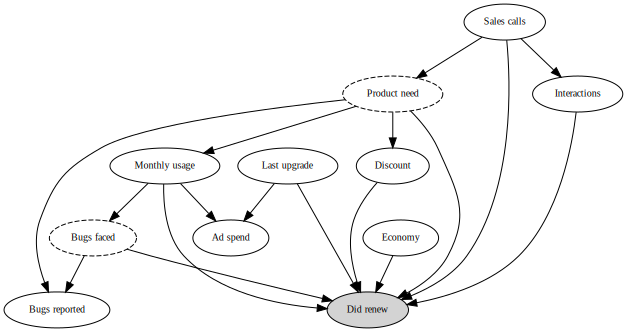

In [20]:
# Define the variable names and the graph structure for the causal model
# We already defined the actual model when we created the synthetic data set (!)

# Variable names
names = [
    "Bugs reported",
    "Monthly usage",
    "Sales calls",
    "Economy",
    "Discount",
    "Last upgrade",
    "Ad spend",
    "Interactions",
]
# Start graph object
g = graphviz.Digraph()
for name in names:
    g.node(name, fontsize="10")
# Draw nodes
g.node("Product need", style="dashed", fontsize="10")
g.node("Bugs faced", style="dashed", fontsize="10")
g.node("Did renew", style="filled", fontsize="10")

g.edge("Product need", "Did renew")
g.edge("Product need", "Discount")
g.edge("Product need", "Bugs reported")
g.edge("Product need", "Monthly usage")
g.edge("Discount", "Did renew")
g.edge("Monthly usage", "Bugs faced")
g.edge("Monthly usage", "Did renew")
g.edge("Monthly usage", "Ad spend")
g.edge("Economy", "Did renew")
g.edge("Sales calls", "Did renew")
g.edge("Sales calls", "Product need")
g.edge("Sales calls", "Interactions")
g.edge("Interactions", "Did renew")
g.edge("Bugs faced", "Did renew")
g.edge("Bugs faced", "Bugs reported")
g.edge("Last upgrade", "Did renew")
g.edge("Last upgrade", "Ad spend")

g  # show the graph

### Train an extreme gradient boosting model

In [21]:
# Create an extreme gradient boosting model to predict the housing prices from the available features (ensemble of regression trees)
# Regression model for the numeric variable "Did renew" (probability of renewal) - issues: linear probability model can go beyond [0,1]

model_xgb_causal = xgboost.XGBRegressor(
    n_estimators=100,  # number of trees
    max_depth=2,  # maximum depth of each tree (here we are allowing for two levels of splits: shallow trees)
)
# Other parameters set to default values, more information in the documentation or help(xgboost.XGBRegressor)

# Fit the model to the training data
model_xgb_causal = model_xgb_causal.fit(X_train, y_train)
print(
    f"Shallow Tree Accuracy on Train Data: {model_xgb_causal.score(X_train, y_train)}"
)
print(f"Shallow Tree Accuracy on Test Data: {model_xgb_causal.score(X_test, y_test)}")

# Generate predictions of the model in the test data

y_pred_test = model_xgb_causal.predict(X_test)


Shallow Tree Accuracy on Train Data: 0.5260178172959318
Shallow Tree Accuracy on Test Data: 0.4905308882113001


### Model interpretation with SHAP values

**Discount, ad spend, and number of bugs reported are the top three factors** driving the model’s prediction of the renewal probability. 

Let's see why these give us naive/incorrect results. 

Take a look at the predicted feature effect on the predicted renew probability for **bugs reported** and **ad spend**. According to the (causal) data generating process, these features should not influence the renew probability.

However, SHAP assesses the influence of a feature in the predicted model (how does this feature contribute to predictions?) and not its causal influence (how does it affect the target?).

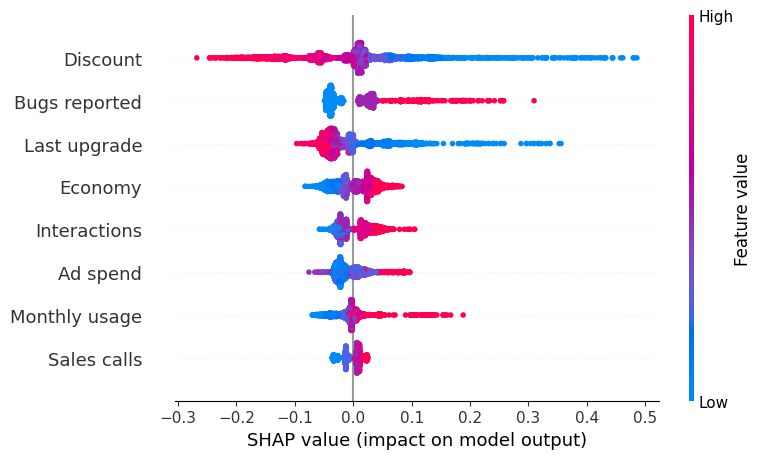

In [22]:
# Create an "explainer" object to explain the model predictions
explainer_causal = shap.Explainer(
    model_xgb_causal,
    X_test,  # use the test data
)

# Compute the SHAP values for the test data
shap_values_causal = explainer_causal(X_test)

# Visualize several features using a beeswarm plot
shap.summary_plot(shap_values_causal)


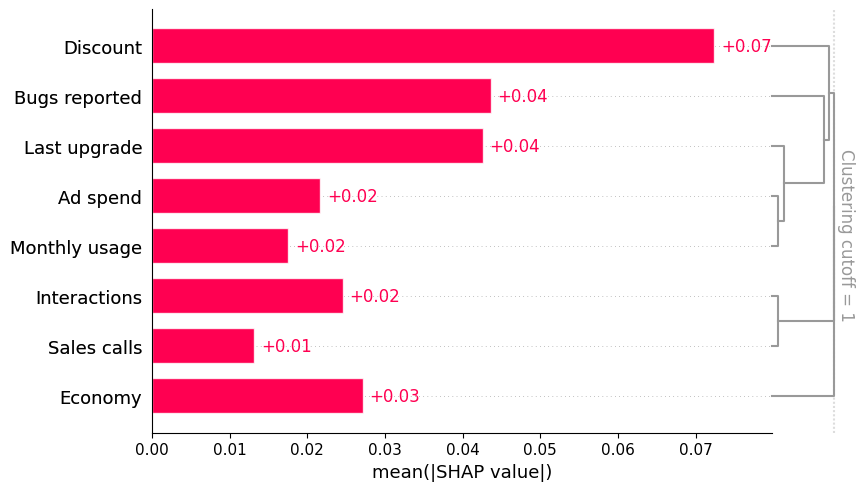

In [23]:
# Cluster the resuls

clust = shap.utils.hclust(X, y, linkage="single")
shap.plots.bar(shap_values_causal, clustering=clust, clustering_cutoff=1)

### Unintuitive direction of "effects"

Higher number of bugs reported -> higher renewal probability?
Higher discount -> lower renewal probability?

Remember: in the **true (causal) model** discount and bugs reported are affected by **product need** and **bugs faced** which are unobserved features in our setting. These are unmeasured confounding features.

Users who **report more bugs** are encountering more bugs because they have **higher product usage**, and they are also **more likely to report those bugs** because they **need the product more**. 

**Product need** has its own direct causal effect on renewal, but it is unobservable. So, we measure a **small negative direct effect of bugs faced** and a **large positive confounding effect from product need**. 

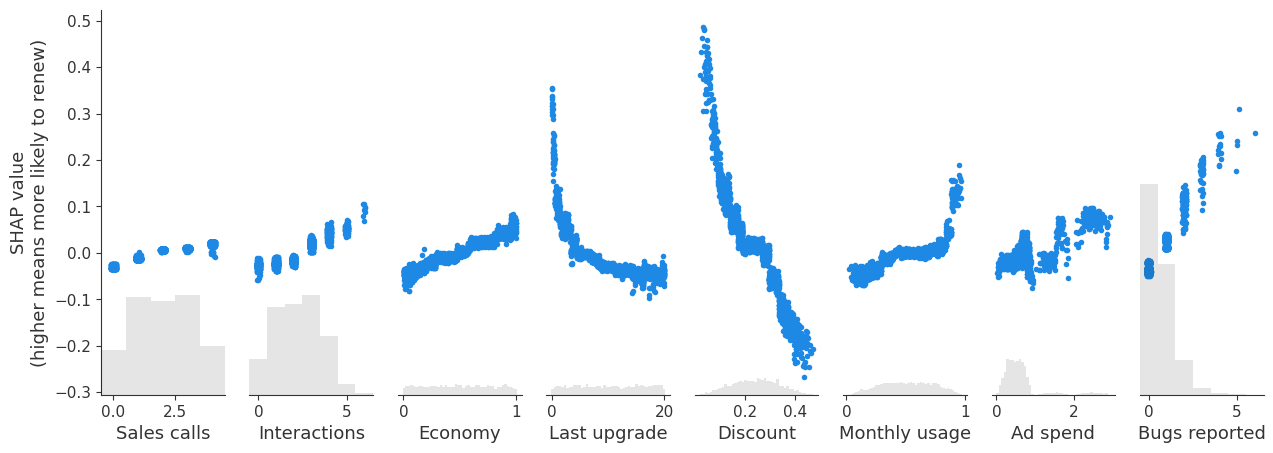

In [24]:
# Scatter plots with SHAP values for selected features

shap.plots.scatter(
    shap_values_causal, ylabel="SHAP value\n(higher means more likely to renew)"
)

### Inspect SHAP values against the true (causal= effect of each feature 

We can produce this graph because in this synthetic example we know the data generating process. In real applications we are not able to do that.

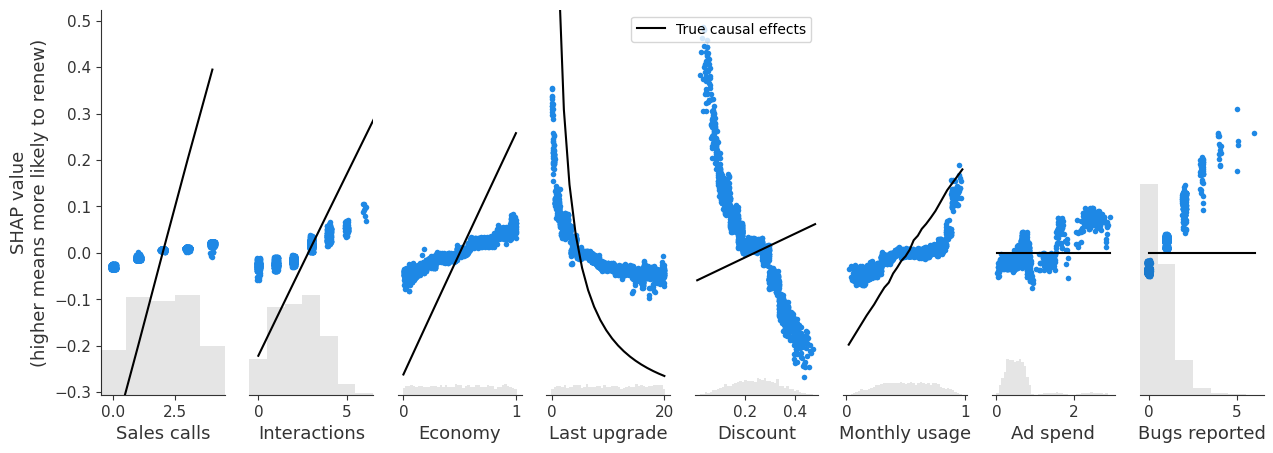

In [25]:
# Function to plot the true marginal causal effects


def marginal_effects(
    generative_model, num_samples=100, columns=None, max_points=20, logit=True, seed=0
):
    """Helper function to compute the true marginal causal effects."""
    X = generative_model(num_samples)
    if columns is None:
        columns = X.columns
    ys = [[] for _ in columns]
    xs = [X[c].values for c in columns]
    xs = np.sort(xs, axis=1)
    xs = [xs[i] for i in range(len(xs))]
    for i, c in enumerate(columns):
        xs[i] = np.unique(
            [
                np.nanpercentile(xs[i], v, method="nearest")
                for v in np.linspace(0, 100, max_points)
            ]
        )
        for x in xs[i]:
            Xnew = generative_model(num_samples, fixed={c: x}, seed=seed)
            val = Xnew["Did renew"].mean()
            if logit:
                val = scipy.special.logit(val)
            ys[i].append(val)
        ys[i] = np.array(ys[i])
    ys = [ys[i] - ys[i].mean() for i in range(len(ys))]
    return list(zip(xs, ys))


# Make the plot
shap.plots.scatter(
    shap_values_causal,
    ylabel="SHAP value\n(higher means more likely to renew)",
    overlay={"True causal effects": marginal_effects(generator, 10000, X.columns)},
)


## Causal Forest using econML

Inspect the same data set using causal forests to assess a **potential causal effect of ad spend** using double machine learning (DML). 
- Model 1: predict the treatment variable using the covariates, obtain residuals
- Model 2: predict the target using the covariates (without the treatment), obtain residuals
- Model 3: Use the unexplained variation (residuals) in the treatment to explain the unexplained variation (residuals) in the target.

Note the differences to:
- **Two-stage-least squares (2SLS):** 1. predict the treatment using instruments and covariates, 2. predict the target using the predicted treatment and covariates
- **Control function approach:** 1. predict the treatment using instruments and covariates, obtain residuals, 2. predict the target using the residuals, the treatment and the covariates

In [26]:
# Prepare the variables

treatment = "Ad spend"
outcome = "Did renew"
observable_covariates = [
    "Bugs reported",
    "Monthly usage",
    "Sales calls",
    "Economy",
    "Discount",
    "Last upgrade",
    "Interactions",
]
unobservable_covariates = [
    "Product need",
    "Bugs faced",
]
observables = [treatment, outcome] + observable_covariates

In [27]:
# Estimate the model

causal_forest = CausalForestDML(
    criterion="het",  # focus on obtaining heterogeneous treatment effects
    n_estimators=100,  # number of models
    max_samples=0.5,  # fraction of observations to draw from the dataset to train each base model
    # the treatment variable we will investigate is continuous (not discrete)
    discrete_treatment=False,
    # use honest splitting (separate samples for splitting and estimating treatment effects)
    honest=True,
    inference=True,  # infer treatment effect estimates
    cv=10,  # 10-fold cross validation
    model_t=LassoCV(),  # model to use for the treatment variable (elationship between covariated and treatment), here Lasso regression with cross-validation
    model_y=LassoCV(),  # model to use for the outcome variable, also Lasso regression with cross-validation - control for confounders and isolate the causal effect
)

### Estimate the Conditional Average Treatment Effect (CATE) with the test set

In [28]:
# Fit train data to causal forest model

causal_forest.fit(
    Y=y,
    T=X[treatment],
    X=X[observable_covariates],
    W=None,  # effect_modifiers
)
# Estimate the Conditional Average Treatment Effect (CATE) with the test set

print(causal_forest.const_marginal_ate(X_test[observable_covariates]))


0.11933023787601833


### Use causal forest model to estimate treatment effects

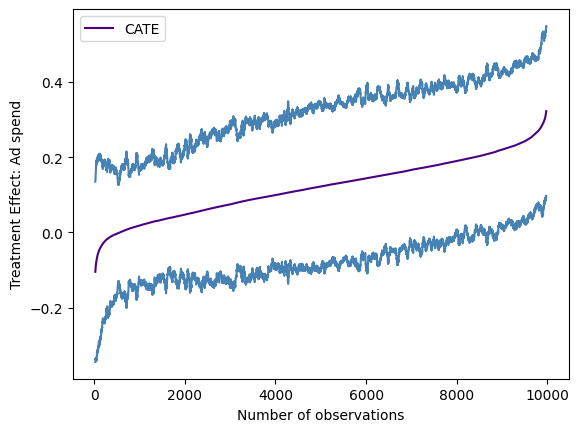

In [29]:
# use causal forest model to estimate treatment effects
treatment_effects = causal_forest.effect(X[observable_covariates])

# calculate lower bound and upper bound confidence intervals
lb, ub = causal_forest.effect_interval(X[observable_covariates], alpha=0.05)

# convert arrays to pandas dataframes for plotting
te_df = pd.DataFrame(treatment_effects, columns=["cate"])
lb_df = pd.DataFrame(lb, columns=["lb"])
ub_df = pd.DataFrame(ub, columns=["ub"])

# merge dataframes and sort
df = te_df.merge(lb_df, left_on=te_df.index, right_on=lb_df.index, how="left")
df.drop(columns=["key_0"], inplace=True)
df = df.merge(ub_df, left_on=df.index, right_on=ub_df.index, how="left")
df.drop(columns=["key_0"], inplace=True)
df.sort_values("cate", inplace=True, ascending=True)
df.reset_index(inplace=True, drop=True)

# calculate rolling mean
z = df.rolling(window=50, center=True).mean()


fig, ax = plt.subplots()
# plot lines for treatment effects and confidence intervals
ax.plot(z["cate"], label="CATE", color="indigo")
ax.plot(z["lb"], color="steelblue")
ax.plot(z["ub"], color="steelblue")
# label axes and create legend
ax.set_ylabel(f"Treatment Effect: {treatment}")
ax.set_xlabel("Number of observations")
ax.legend()
plt.show()

### Repeat the SHAP values using the results of the causal forest model

Which differences do you note?

 99%|===================| 2471/2500 [00:37<00:00]        

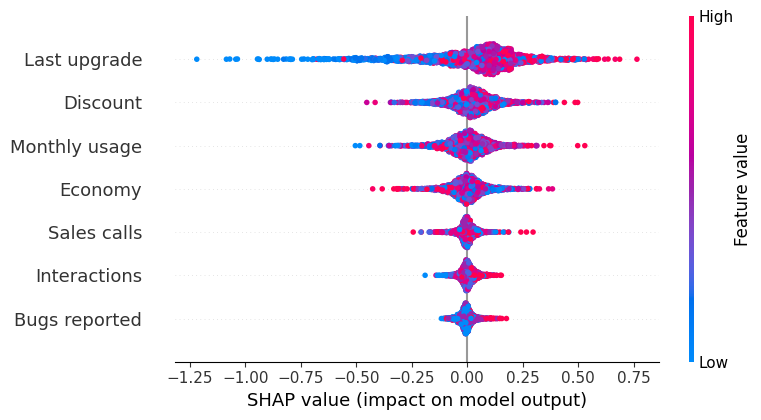

In [30]:
# Generate SHAP values for the test data using only the observable covariates
shap_values = causal_forest.shap_values(X_test[observable_covariates])
# Extract the SHAP values for the outcome considering the treatment variable
shap.summary_plot(shap_values[outcome][treatment])

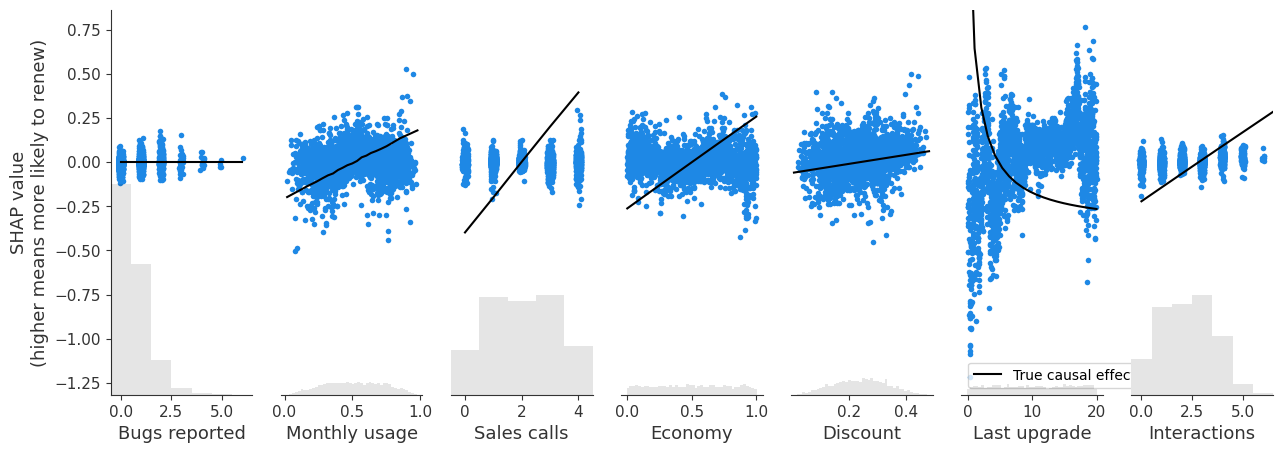

In [34]:
# Repeat the scatter plot with the causal effects
shap.plots.scatter(
    shap_values[outcome][treatment],
    ylabel="SHAP value\n(higher means more likely to renew)",
    overlay={
        "True causal effects": marginal_effects(
            generator, 10000, X_test[observable_covariates].columns
        )
    },
)


## Modeling using the Causal Graph Structure

Four Steps:
- Modeling
- Identification
- Estimation
- Refutation

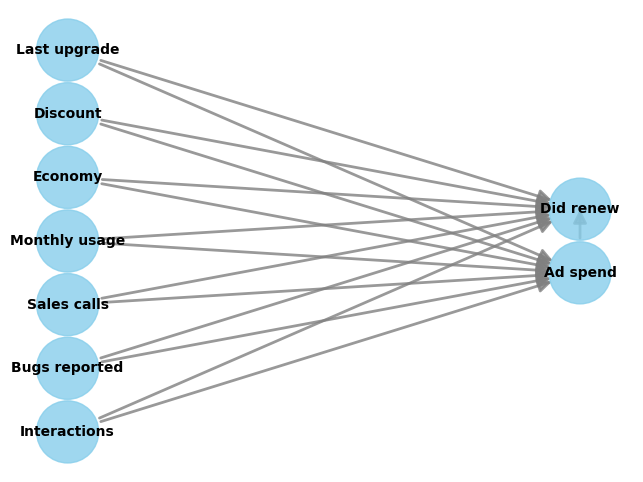

In [35]:
# Default model if we simply plug in the data
causal_graph_model_default = CausalModel(
    data=df_full,
    treatment=treatment,
    outcome=outcome,
    common_causes=observable_covariates,
    instruments=None,
    effect_modifiers=None,
)
causal_graph_model_default.view_model()

In [36]:
# Define the treatment variable
treatment = "Ad spend"

/home/vscode/venv/lib/python3.11/site-packages/dowhy/causal_model.py:582: UserWarning: 2 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


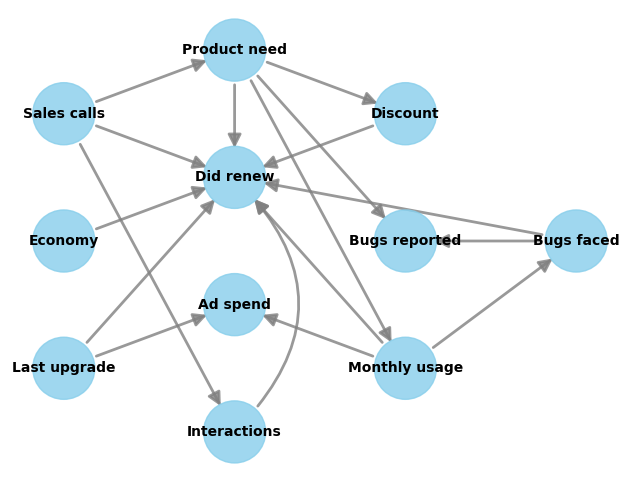

In [37]:
# I. Create a causal model from the data and the true causal graph.
causal_graph_model = CausalModel(
    data=df_full[observables],
    treatment=treatment,
    outcome=outcome,
    graph=g.source,  # true graph we generated earlier
)
causal_graph_model.view_model()

In [38]:
# II. Identify causal effect and return target estimands
identified_estimand = causal_graph_model.identify_effect(
    proceed_when_unidentifiable=True)
print(identified_estimand)

No directed path from ['Ad spend'] to ['Did renew'] in the causal graph.
Causal effect is zero.


### And we're done! The Causal effect of "Ad spend" is zero!

Let's continue the analysis for "Sales calls" instead

In [39]:
treatment = "Sales calls"

/home/vscode/venv/lib/python3.11/site-packages/dowhy/causal_model.py:582: UserWarning: 2 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


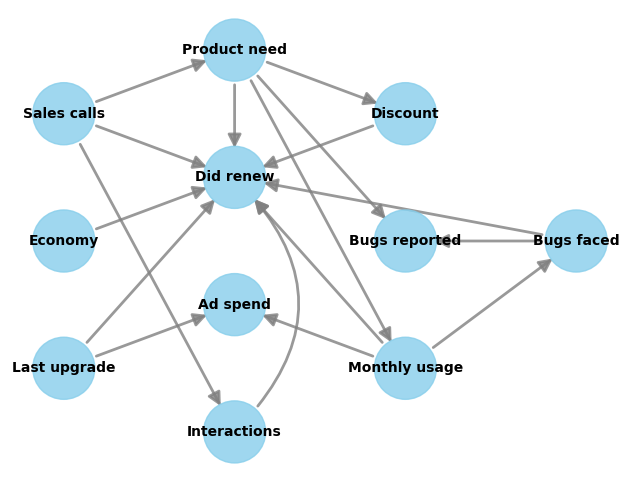

In [40]:
# I. Create a causal model from the data and the true causal graph.
causal_graph_model = CausalModel(
    data=df_full[observables],
    treatment=treatment,
    outcome=outcome,
    graph=g.source,
)
causal_graph_model.view_model()

In [41]:
# II. Identify causal effect and return target estimands
identified_estimand = causal_graph_model.identify_effect(
    proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                     
──────────────(E[Did renew])
d[Sales calls]              
Estimand assumption 1, Unconfoundedness: If U→{Sales calls} and U→Did renew then P(Did renew|Sales calls,,U) = P(Did renew|Sales calls,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [42]:
# III. Estimate the target estimand using a statistical method.
with warnings.catch_warnings():
    # dowhy version 0.11.1
    # dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated.
    warnings.simplefilter("ignore", FutureWarning)
    causal_estimate = causal_graph_model.estimate_effect(
        identified_estimand,
        method_name="backdoor.generalized_linear_model",
        method_params={
            "glm_family": statsmodels.api.families.Binomial()  # logistic regression
        },
    )
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                     
──────────────(E[Did renew])
d[Sales calls]              
Estimand assumption 1, Unconfoundedness: If U→{Sales calls} and U→Did renew then P(Did renew|Sales calls,,U) = P(Did renew|Sales calls,)

## Realized estimand
b: Did renew~Sigmoid(Sales calls+Sales calls*Economy+Sales calls*Last upgrade)
Target units: 

## Estimate
Mean value: 0.035206337941664057
### Conditional Estimates
__categorical__Economy  __categorical__Last upgrade
(-0.000894, 0.205]      (0.0, 4.056]                   0.044274
                        (4.056, 8.141]                 0.032175
                        (8.141, 12.155]                0.020268
                        (12.155, 16.078]               0.009389
                        (16.078, 19.997]              -0.001100
(0.205, 0.403]          (0.0, 4.056]                   0.05

/home/vscode/venv/lib/python3.11/site-packages/dowhy/causal_estimator.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[prefix + str(em)] = pd.qcut(data[em], num_quantiles, duplicates="drop")


In [43]:
# IV. Refute the obtained estimate using multiple robustness checks.
with warnings.catch_warnings():
    # dowhy version 0.11.1
    # dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated.
    warnings.simplefilter("ignore", FutureWarning)
    # statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in scalar divide
    warnings.simplefilter("ignore", RuntimeWarning)
    refute_results = causal_graph_model.refute_estimate(
        identified_estimand,
        causal_estimate,
        method_name="placebo_treatment_refuter"
    )
print(refute_results)

Refute: Use a Placebo Treatment
Estimated effect:0.035206337941664057
New effect:0.0
p value:1.0



### What if our domain knowledge had been wrong?

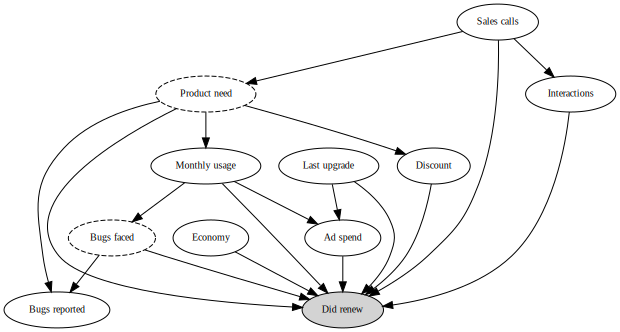

In [44]:
treatment = "Ad spend"
g_flawed = g.copy()
g_flawed.edge("Ad spend", "Did renew")
g_flawed

/home/vscode/venv/lib/python3.11/site-packages/dowhy/causal_model.py:582: UserWarning: 2 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


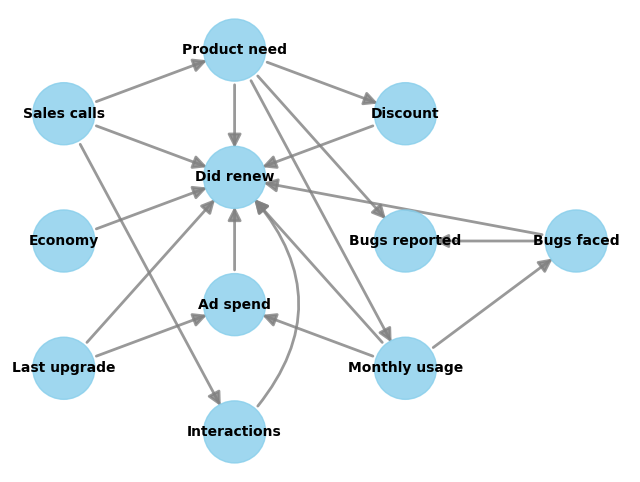

In [45]:
# I. Create a causal model from the data and given graph.
causal_graph_model = CausalModel(
    data=df_full[observables],
    treatment=treatment,
    outcome=outcome,
    graph=g_flawed.source,
)
causal_graph_model.view_model()

In [46]:
# II. Identify causal effect and return target estimands
identified_estimand = causal_graph_model.identify_effect(
    proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                              
───────────(E[Did renew|Monthly usage,Last upgrade])
d[Ad spend]                                         
Estimand assumption 1, Unconfoundedness: If U→{Ad spend} and U→Did renew then P(Did renew|Ad spend,Monthly usage,Last upgrade,U) = P(Did renew|Ad spend,Monthly usage,Last upgrade)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [47]:
# III. Estimate the target estimand using a statistical method.
with warnings.catch_warnings():
    # dowhy version 0.11.1
    # dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated.
    warnings.simplefilter("ignore", FutureWarning)
    causal_estimate = causal_graph_model.estimate_effect(
        identified_estimand,
        method_name="backdoor.generalized_linear_model",
        method_params={
            "glm_family": statsmodels.api.families.Binomial()  # logistic regression
        },
    )
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

/home/vscode/venv/lib/python3.11/site-packages/dowhy/causal_estimator.py:233: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[prefix + str(em)] = pd.qcut(data[em], num_quantiles, duplicates="drop")


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                              
───────────(E[Did renew|Monthly usage,Last upgrade])
d[Ad spend]                                         
Estimand assumption 1, Unconfoundedness: If U→{Ad spend} and U→Did renew then P(Did renew|Ad spend,Monthly usage,Last upgrade,U) = P(Did renew|Ad spend,Monthly usage,Last upgrade)

## Realized estimand
b: Did renew~Sigmoid(Ad spend+Monthly usage+Last upgrade+Ad spend*Interactions+Ad spend*Discount+Ad spend*Economy)
Target units: 

## Estimate
Mean value: 0.11788250078700191
### Conditional Estimates
__categorical__Interactions  __categorical__Discount  __categorical__Economy
(-0.001, 1.0]                (0.0091, 0.157]          (-0.000894, 0.205]        0.159637
                                                      (0.205, 0.403]            0.206181
                          

In [48]:
# IV. Refute the obtained estimate using multiple robustness checks.
with warnings.catch_warnings():
    # dowhy version 0.11.1
    # dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated.
    warnings.simplefilter("ignore", FutureWarning)
    # statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in scalar divide
    warnings.simplefilter("ignore", RuntimeWarning)
    refute_results = causal_graph_model.refute_estimate(
        identified_estimand,
        causal_estimate,
        method_name="placebo_treatment_refuter"
    )
print(refute_results)

Refute: Use a Placebo Treatment
Estimated effect:0.11788250078700191
New effect:4.996003610813204e-16
p value:0.0



The refutation step managed to identify the error.